In [1]:
from __future__ import print_function, division
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon

In [2]:
df = pd.read_csv('final_clean_data_201501_06.csv', index_col=0)
print ("Shape of data\n{}".format(df.shape))
df.head()

Shape of data
(158270, 23)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,dayofweek,dayofyear,day_and_hour,pickups,geohash_pickup,FHV_count,DATE,DAILYSunrise,DAILYSunset,wind_speed_average,...,temperature_max,temperature_min,fastest_2minute_windspeed,fog,heavy_fog,ice_pellets,glaze_rime,smoke_haze,EVENT_TYPE,month
0,Thursday,29,2914,1,SHBHR,4252,2015-01-29,709,1710,3.80,...,36.0,19.0,14.1,0.0,0.0,0.0,0.0,0.0,-1,1
1,Wednesday,21,2111,1,SHBI3,3456,2015-01-21,715,1700,4.25,...,36.0,25.0,10.1,0.0,0.0,0.0,0.0,0.0,-1,1
2,Saturday,10,109,1,SHBJ3,3027,2015-01-10,720,1647,8.05,...,23.0,16.0,18.1,0.0,0.0,0.0,0.0,0.0,-1,1
3,Sunday,11,116,1,SHBJ3,4476,2015-01-11,720,1649,6.04,...,37.0,18.0,14.1,0.0,0.0,0.0,0.0,0.0,-1,1
4,Monday,12,1210,1,SHBJ3,4176,2015-01-12,719,1650,3.80,...,39.0,35.0,12.1,1.0,0.0,1.0,0.0,0.0,-1,1


In [3]:
df1 = df[['pickups', 'geohash_pickup']]

In [4]:
len(df1.geohash_pickup.unique())

707

In [5]:
df1 = df1.groupby('geohash_pickup', as_index=False).agg({'pickups':'sum'})
df1.head()

,geohash_pickup,pickups
0,SHBHA,1
1,SHBHR,1
2,SHBI3,1
3,SHBIR,1
4,SHBIy,1


In [6]:
df1['geohash_factorize'] = pd.factorize(df1['geohash_pickup'])[0]

In [7]:
import geohash_hilbert as ghh

In [8]:
ghh.rectangle('SHFkk')

{'bbox': (-73.795166015625, 40.6439208984375, -73.7841796875, 40.6494140625),
 'geometry': {'coordinates': [[(-73.795166015625, 40.6439208984375),
    (-73.7841796875, 40.6439208984375),
    (-73.7841796875, 40.6494140625),
    (-73.795166015625, 40.6494140625),
    (-73.795166015625, 40.6439208984375)]],
  'type': 'Polygon'},
 'properties': {'bits_per_char': 6,
  'code': 'SHFkk',
  'lat': 40.64666748046875,
  'lat_err': 0.00274658203125,
  'lng': -73.7896728515625,
  'lng_err': 0.0054931640625},
 'type': 'Feature'}

In [9]:
coords = ghh.rectangle('SHFkk')['geometry']['coordinates'][0]

In [10]:
poly_jfk = Polygon(coords)

In [11]:
poly_jfk.area

6.034970283508301e-05

In [12]:
df1.geohash_pickup.unique()

array(['SHBHA', 'SHBHR', 'SHBI3', 'SHBIR', 'SHBIy', 'SHBJ0', 'SHBJ2',
       'SHBJ3', 'SHBJ4', 'SHBJ5', 'SHBJ6', 'SHBJ7', 'SHBJ8', 'SHBJ9',
       'SHBJ@', 'SHBJA', 'SHBJQ', 'SHBJR', 'SHBJU', 'SHBJV', 'SHBJW',
       'SHBJX', 'SHBJY', 'SHBJZ', 'SHBJ_', 'SHBJa', 'SHBJb', 'SHBJc',
       'SHBJd', 'SHBJe', 'SHBJf', 'SHBJg', 'SHBJh', 'SHBJi', 'SHBJj',
       'SHBJk', 'SHBJl', 'SHBJm', 'SHBJn', 'SHBJo', 'SHBJp', 'SHBJq',
       'SHBJr', 'SHBJs', 'SHBJt', 'SHBJu', 'SHBJv', 'SHBJw', 'SHBJx',
       'SHBJy', 'SHBJz', 'SHBK0', 'SHBK5', 'SHBKK', 'SHBKa', 'SHBKc',
       'SHBKl', 'SHBKq', 'SHBKu', 'SHBKv', 'SHBKw', 'SHBKz', 'SHBL0',
       'SHBL3', 'SHBL4', 'SHBL5', 'SHBLA', 'SHBLB', 'SHBLC', 'SHBLE',
       'SHBLG', 'SHBLH', 'SHBLI', 'SHBLN', 'SHBLQ', 'SHBLR', 'SHBLS',
       'SHBLT', 'SHBLW', 'SHBLZ', 'SHBLd', 'SHBLg', 'SHBLm', 'SHBLs',
       'SHBLt', 'SHBLu', 'SHBLv', 'SHBLw', 'SHBLy', 'SHBLz', 'SHBM0',
       'SHBM1', 'SHBM2', 'SHBM3', 'SHBM8', 'SHBMA', 'SHBMB', 'SHBMC',
       'SHBMD', 'SHB

In [13]:
geohashlist = list(df1.geohash_pickup.unique())

In [14]:
len(geohashlist)

707

In [15]:
#df.drop(['geometry', 'lonlat'], axis=1, inplace=True)
df1.reset_index(drop=True, inplace=True)
df1.head()

,geohash_pickup,pickups,geohash_factorize
0,SHBHA,1,0
1,SHBHR,1,1
2,SHBI3,1,2
3,SHBIR,1,3
4,SHBIy,1,4


In [16]:
#add a column of geometry to dataframe
geo = {}
for i in range(len(geohashlist)):
    coords = ghh.rectangle(geohashlist[i])['geometry']['coordinates'][0]
    geo[i] = Polygon(coords)
s = pd.Series(geo, name='geometry')
geo = pd.DataFrame(s)
df1 = df1.merge(geo, left_index=True, right_index=True)
df1.head()

,geohash_pickup,pickups,geohash_factorize,geometry
0,SHBHA,1,0,"POLYGON ((-74.06982421875 40.8416748046875, -7..."
1,SHBHR,1,1,"POLYGON ((-74.058837890625 40.8526611328125, -..."
2,SHBI3,1,2,"POLYGON ((-74.014892578125 40.814208984375, -7..."
3,SHBIR,1,3,"POLYGON ((-74.06982421875 40.80322265625, -74...."
4,SHBIy,1,4,"POLYGON ((-74.02587890625 40.78125, -74.014892..."


In [17]:
len(df1)

707

In [18]:
df1 = gpd.GeoDataFrame(df1)
df1.crs = from_epsg(4326)
df1 = df1.to_crs(epsg=2263)

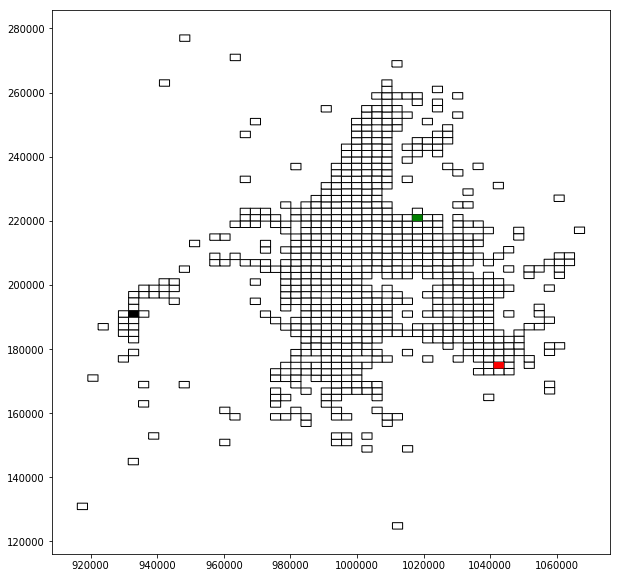

In [19]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
df1.plot(column=None, color="white", edgecolor="black", ax=ax)
df1[df1.geohash_pickup == 'SHFkk'].plot(ax=ax, color='r')
df1[df1.geohash_pickup == 'SHG0t'].plot(ax=ax, color='g')
df1[df1.geohash_pickup == 'SHGTe'].plot(ax=ax, color='k')
plt.savefig('geohash_pickup_toairport', dpi=500, transparent=True)
plt.show()

In [20]:
import choroplethNYC as cp

In [21]:
os.system("curl -O https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip")
os.system("mv " + "taxi_zones.zip " + os.getenv("PUIDATA"))
os.system("unzip " + os.getenv("PUIDATA") + "/taxi_zones.zip -d " + os.getenv("PUIDATA") + "/taxi_zones")
zone = gpd.read_file(os.getenv("PUIDATA") + "/taxi_zones" + "/taxi_zones.shp")
zone.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


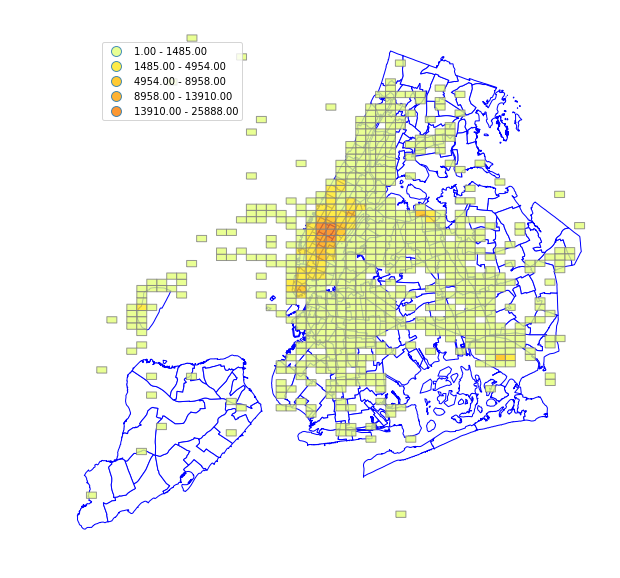

In [22]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
cp.choroplethNYC(zone, column=None, color="white", edgecolor="blue", lw=1, ax=ax)
df1.plot(column='pickups', cmap='Wistia', alpha=0.8, edgecolor="grey", linewidth=1,
           ax=ax, scheme="fisher_jenks", legend=True, k=5)
plt.legend(loc=2)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
#df1[df1.geohash_pickup == 'SHFkk'].plot(ax=ax, color='r')
#df1[df1.geohash_pickup == 'SHG0t'].plot(ax=ax, color='g')
#df1[df1.geohash_pickup == 'SHGTe'].plot(ax=ax, color='k')
plt.savefig('geohash_pickup_toairport_value', dpi=500, transparent=True)
plt.show()